# Terry Stops Classification

Student name: Cassidy Exum

Student pace: self paced

Scheduled project review date/time: Undetermined

Instructor name: Morgan Jones

Blog post URL: https://exumexaminesdata.blogspot.com/2022/10/the-chess-cheating-scandal-and-72-page.html

## Objective - Create a classification model that can predict whether an arrest was made or not made

The data for this project was obtained from the seattle .gov website at the follow link: https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

The stakeholder is a non-profit organization researching police stop data. 

Description of problem taken from Flatiron phase 3 dataset github located: https://github.com/learn-co-curriculum/dsc-phase-3-choosing-a-dataset

> In Terry v. Ohio, a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers.

> Build a classifier to predict whether an arrest was made after a Terry Stop, given information about the presence of weapons, the time of day of the call, etc. This is a binary classification problem. 

> Note that this dataset also includes information about gender and race. You may use this data as well. You could conceivably pitch your project as an inquiry into whether race (of officer or of subject) plays a role in whether or not an arrest is made.

> If you do elect to make use of race or gender data, be aware that this can make your project a highly sensitive one; your discretion will be important, as well as your transparency about how you use the data and the ethical issues surrounding it.

Brief idea of how I should do this - 
1. fix data
2. get dummies
3. train model (Use Logistic as Baseline model)
4. iterate (xgboost/random forest -> GridSearchCV xgboost/random forest)

### Phase 1 - Imports and Data exploration
Import the data set, explore, clean, preprocess, and reorginize the data. 

In [116]:
#relevant imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn imports
# Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [117]:
#import data and print head

df = pd.read_csv('terry_stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-8,20220000063036,32023419019,Field Contact,-,6805,1973,M,White,...,09:34:02.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - KQ/DM RELIEF,N,Y,West,K,K3
1,-,-8,20220000233868,35877423282,Field Contact,-,8881,1988,M,Asian,...,19:20:16.0000000,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),--DISTURBANCE - OTHER,911,TRAINING - FIELD TRAINING SQUAD,N,Y,South,O,O1
2,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
3,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00.0000000,-,-,-,NaN,N,-,-,-,-


Preliminary thoughts

There are a few ID type columns I don't need such as Subject ID, GO/ SC Num , Terry Stop ID.

There are a few officer specific columns which may or may not be useful such as Officer ID, YOB, officer squad

Target = Stop Resolution

In [118]:
#check entire dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         53654 non-null  object
 1   Subject ID                53654 non-null  int64 
 2   GO / SC Num               53654 non-null  int64 
 3   Terry Stop ID             53654 non-null  int64 
 4   Stop Resolution           53654 non-null  object
 5   Weapon Type               53654 non-null  object
 6   Officer ID                53654 non-null  object
 7   Officer YOB               53654 non-null  int64 
 8   Officer Gender            53654 non-null  object
 9   Officer Race              53654 non-null  object
 10  Subject Perceived Race    53654 non-null  object
 11  Subject Perceived Gender  53654 non-null  object
 12  Reported Date             53654 non-null  object
 13  Reported Time             53654 non-null  object
 14  Initial Call Type     

In [119]:
# Create Month and Weak features from Reported Date
df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['Month'] = df['Reported Date'].apply(lambda x: x.month)

In [120]:
#Create a function to map the day to a week 1-4. Create new feature, week of the month.
def week_map(x):
    if x.day<=7:
        return 1
    elif x.day<=14:
        return 2
    elif x.day<=21:
        return 3
    else:
        return 4

df['Week'] = df['Reported Date'].apply(week_map)

In [121]:
# Convert Reported Time to binary night or day
df['day/night'] = df['Reported Time'].apply(lambda x: 'night' if '00:00' <= x <= '05:00' or '19:00' <= x <= '23:00' else 'day')

In [122]:
# ID columns, overlapping columns, and anything else
to_drop = ['Subject ID', 
           'GO / SC Num', 
           'Terry Stop ID', 
           'Officer ID',    
           'Reported Time',
           'Initial Call Type',
           'Final Call Type',
           'Officer Squad']
df.drop(to_drop, axis=1, inplace=True)
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Call Type,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Month,Week,day/night
0,-,Field Contact,-,1973,M,White,DUPLICATE,DUPLICATE,2022-03-14 00:00:00+00:00,ONVIEW,N,Y,West,K,K3,3,2,day
1,-,Field Contact,-,1988,M,Asian,DUPLICATE,DUPLICATE,2022-09-02 00:00:00+00:00,911,N,Y,South,O,O1,9,1,night
2,-,Arrest,None,1984,M,Black or African American,Asian,Male,2015-10-16 00:00:00+00:00,-,N,N,South,O,O2,10,3,day
3,-,Field Contact,None,1965,M,White,-,-,2015-03-19 00:00:00+00:00,-,N,N,-,-,-,3,3,day
4,-,Field Contact,None,1961,M,White,White,Male,2015-03-21 00:00:00+00:00,-,N,-,-,-,-,3,3,night


In [123]:
#check target variable
df['Stop Resolution'].value_counts()

Field Contact               23006
Offense Report              16599
Arrest                      13131
Referred for Prosecution      728
Citation / Infraction         190
Name: Stop Resolution, dtype: int64

I can reorganize this column to only be 'Arrest' and 'No Arrest' or 1 and 0.

In [124]:
# Change everything other than Arrest to 0, and Arrest to 1
df.loc[ df['Stop Resolution'] != 'Arrest', 'Stop Resolution'] = 0
df.loc[ df['Stop Resolution'] == 'Arrest', 'Stop Resolution'] = 1
df['Stop Resolution'].value_counts()

0    40523
1    13131
Name: Stop Resolution, dtype: int64

In [125]:
# Set type
df['Stop Resolution'] = df['Stop Resolution'].astype('int64')

In [126]:
#Check Call Type
df['Call Type'].value_counts()

911                              24803
-                                13514
ONVIEW                           11184
TELEPHONE OTHER, NOT 911          3685
ALARM CALL (NOT POLICE ALARM)      446
TEXT MESSAGE                        21
SCHEDULED EVENT (RECURRING)          1
Name: Call Type, dtype: int64

In [127]:
#Check Precinct column
df['Precinct'].value_counts()

West         14070
North        11699
-            10240
East          6904
South         6363
Southwest     2320
SouthWest     1775
Unknown        200
OOJ             61
FK ERROR        22
Name: Precinct, dtype: int64

In [128]:
# Impute - as unknown some values
# Impute FK Error as Unknown
# Fix Southwest
df.loc[ df['Precinct'] == '-', 'Precinct'] = 'Unknown'
df.loc[ df['Precinct'] == 'FK ERROR', 'Precinct'] = 'Unknown'
df.loc[ df['Precinct'] == 'SouthWest', 'Precinct'] = 'Southwest'

In [129]:
#Check sector column
df['Sector'].value_counts()

-     10477
K      4411
M      4369
E      3589
N      3219
D      3094
B      2524
F      2487
R      2353
L      2335
Q      2192
O      2031
S      1980
U      1963
G      1742
J      1657
W      1606
C      1572
99       53
Name: Sector, dtype: int64

In [130]:
# impute 99 to be -
df.loc[ df['Sector'] == '99', 'Sector'] = '-'

In [131]:
#Check Beat Column
df['Beat'].value_counts()

-      10385
K3      2374
M3      1950
N3      1608
E2      1529
M2      1215
M1      1207
D1      1202
N2      1187
D2      1166
E1      1153
K2      1100
R2      1076
Q3      1045
F2      1017
B1       941
K1       937
B2       934
U2       922
E3       906
O1       844
L2       798
L1       790
S2       788
F3       756
L3       747
D3       726
F1       714
R1       697
W2       680
U1       662
Q2       658
S3       657
B3       651
G2       640
J3       631
O3       626
C1       618
J1       612
G3       607
R3       580
O2       561
C3       553
W1       537
S1       535
G1       494
Q1       489
N1       423
J2       414
C2       402
W3       390
U3       379
99       100
OOJ       39
S          2
Name: Beat, dtype: int64

In [132]:
# impute 99 as -
df.loc[ df['Beat'] == '99', 'Beat'] = '-'

In [133]:
# Check the column
df['Subject Perceived Race'].value_counts()

White                                        26320
Black or African American                    15936
Unknown                                       3526
-                                             1810
Asian                                         1803
Hispanic                                      1684
American Indian or Alaska Native              1514
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       98
DUPLICATE                                        2
Name: Subject Perceived Race, dtype: int64

In [134]:
# drop DUPLICATE and impute - as Unknown
df = df[df['Subject Perceived Race'] != 'DUPLICATE']

In [135]:
# Impute - as unknown
df.loc[ df['Subject Perceived Race'] == '-', 'Subject Perceived Race'] = 'Unknown'
df['Subject Perceived Race'].value_counts()

White                                        26320
Black or African American                    15936
Unknown                                       5336
Asian                                         1803
Hispanic                                      1684
American Indian or Alaska Native              1514
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       98
Name: Subject Perceived Race, dtype: int64

In [136]:
#Check counts of subject gender
df['Subject Perceived Gender'].value_counts()

Male                                                         42251
Female                                                       10749
Unable to Determine                                            326
-                                                              239
Unknown                                                         67
Gender Diverse (gender non-conforming and/or transgender)       20
Name: Subject Perceived Gender, dtype: int64

In [137]:
#impute - and Unable to Determine as Unknown
df.loc[ df['Subject Perceived Gender'] == '-', 'Subject Perceived Gender'] = 'Unknown'
df.loc[ df['Subject Perceived Gender'] == 'Unable to Determine', 'Subject Perceived Gender'] = 'Unknown'
df['Subject Perceived Gender'].value_counts()

Male                                                         42251
Female                                                       10749
Unknown                                                        632
Gender Diverse (gender non-conforming and/or transgender)       20
Name: Subject Perceived Gender, dtype: int64

In [138]:
#check weapon type column
df['Weapon Type'].value_counts()

None                                    32565
-                                       17798
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         967
Handgun                                   342
Blunt Object/Striking Implement           125
Firearm Other                             100
Firearm                                    63
Club, Blackjack, Brass Knuckles            49
Mace/Pepper Spray                          44
Other Firearm                              41
Firearm (unk type)                         15
Taser/Stun Gun                             13
Fire/Incendiary Device                     11
None/Not Applicable                        10
Club                                        9
Rifle                                       8
Shotgun                                     4
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Brass Knuckles                              1
Blackjack                         

In [139]:
# Impute - as None
df.loc[ df['Weapon Type'] == '-', 'Weapon Type'] = 'None'
df['Weapon Type'].value_counts()

None                                    50363
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         967
Handgun                                   342
Blunt Object/Striking Implement           125
Firearm Other                             100
Firearm                                    63
Club, Blackjack, Brass Knuckles            49
Mace/Pepper Spray                          44
Other Firearm                              41
Firearm (unk type)                         15
Taser/Stun Gun                             13
Fire/Incendiary Device                     11
None/Not Applicable                        10
Club                                        9
Rifle                                       8
Shotgun                                     4
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Brass Knuckles                              1
Blackjack                                   1
Name: Weapon Type, dtype: int64

In [140]:
# Simplify Weapon Type Further
# Organize into Blunt Weapons, Sharp Weapons, Firearms
#Firearms
df.loc[ df['Weapon Type'] == 'None/Not Applicable', 'Weapon Type'] = 'None'
df.loc[ df['Weapon Type'] == 'Handgun', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Firearm Other', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Other Firearm', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Firearm (unk type)', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Rifle', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Shotgun', 'Weapon Type'] = 'Firearm'
df.loc[ df['Weapon Type'] == 'Automatic Handgun', 'Weapon Type'] = 'Firearm'

# Blunt Object/Striking Implement 
df.loc[ df['Weapon Type'] == 'Blackjack', 'Weapon Type'] = 'Blunt Object/Striking Implement'
df.loc[ df['Weapon Type'] == 'Brass Knuckles', 'Weapon Type'] = 'Blunt Object/Striking Implement'
df.loc[ df['Weapon Type'] == 'Club', 'Weapon Type'] = 'Blunt Object/Striking Implement'
df.loc[ df['Weapon Type'] == 'Club, Blackjack, Brass Knuckles', 'Weapon Type'] = 'Blunt Object/Striking Implement'
df.loc[ df['Weapon Type'] == 'Personal Weapons (hands, feet, etc.)', 'Weapon Type'] = 'Blunt Object/Striking Implement'

#knifes
df.loc[ df['Weapon Type'] == 'Knife/Cutting/Stabbing Instrument', 'Weapon Type'] = 'Lethal Cutting Instrument'

#Other
df.loc[ df['Weapon Type'] == 'Mace/Pepper Spray', 'Weapon Type'] = 'Other'
df.loc[ df['Weapon Type'] == 'Taser/Stun Gun', 'Weapon Type'] = 'Other'
df.loc[ df['Weapon Type'] == 'Fire/Incendiary Device', 'Weapon Type'] = 'Other'



In [141]:
#check weapon type
df['Weapon Type'].value_counts()

None                               50373
Lethal Cutting Instrument           2449
Firearm                              575
Blunt Object/Striking Implement      187
Other                                 68
Name: Weapon Type, dtype: int64

In [142]:
# Check officer gender
df['Officer Gender'].value_counts()

M    47514
F     6108
N       30
Name: Officer Gender, dtype: int64

In [143]:
# Check officer YOB
df['Officer YOB'].value_counts()

1986    3690
1987    3422
1991    2979
1984    2921
1992    2854
1990    2688
1985    2600
1988    2395
1989    2272
1982    1946
1983    1866
1993    1776
1995    1716
1979    1715
1981    1591
1994    1346
1971    1272
1976    1246
1978    1221
1977    1101
1973    1004
1996     962
1980     935
1967     792
1997     746
1970     670
1968     664
1969     590
1975     579
1974     579
1962     463
1964     459
1972     449
1965     424
1963     265
1966     235
1961     234
1958     222
1959     174
1960     161
1998     123
1900      69
1954      44
1957      43
1953      35
1999      25
2000      23
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
1951       1
Name: Officer YOB, dtype: int64

In [144]:
#yob as type int
df['Officer YOB'].astype('int64')

2        1984
3        1965
4        1961
5        1963
6        1977
         ... 
53649    1977
53650    1996
53651    1973
53652    1978
53653    1995
Name: Officer YOB, Length: 53652, dtype: int64

In [145]:
#drop people born in 1900, 122 year olds arent still officers
df = df[df['Officer YOB'] != 1900]

# turn YOB to age
df['Officer Age Group'] = df['Officer YOB'].apply(
    lambda x: 2022-x)

In [146]:
# Map age to age brackets
def map_age(x):
    if 18 <= x <= 25:
        return '18 - 25'
    elif 26 <= x <= 35:
        return '26 - 35'
    elif 36 <= x <= 45:
        return '36 - 45'
    elif 46 <= x <= 55:
        return '46 - 55'
    elif 56 <= x:
        return '56 and Above'

    
df['Officer Age Group'] = df['Officer Age Group'].apply(map_age)

In [147]:
#check that the map worked
df['Officer Age Group'].value_counts()

26 - 35         22410
36 - 45         19586
46 - 55          7845
56 and Above     2825
18 - 25           917
Name: Officer Age Group, dtype: int64

In [148]:
#drop Officer YOB
df.drop('Officer YOB', axis=1, inplace=True)

In [149]:
#check officer Race
df['Officer Race'].value_counts()

White                            39375
Two or More Races                 3336
Hispanic or Latino                3278
Asian                             2398
Not Specified                     2293
Black or African American         2098
Nat Hawaiian/Oth Pac Islander      472
American Indian/Alaska Native      333
Name: Officer Race, dtype: int64

In [150]:
#Make Not Specified as Unknown
df.loc[ df['Officer Race'] == 'Not Specified', 'Officer Race'] = 'Unknown'

In [151]:
#Check age group column
df['Subject Age Group'].value_counts()

26 - 35         17912
36 - 45         11618
18 - 25         10499
46 - 55          6882
56 and Above     2779
1 - 17           2079
-                1814
Name: Subject Age Group, dtype: int64

In [152]:
# check arrest flag column
df['Arrest Flag'].value_counts()

N    48668
Y     4915
Name: Arrest Flag, dtype: int64

In [153]:
#check frisk flag
df['Frisk Flag'].value_counts()

N    40736
Y    12369
-      478
Name: Frisk Flag, dtype: int64

In [154]:
#final check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53583 entries, 2 to 53653
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Subject Age Group         53583 non-null  object             
 1   Stop Resolution           53583 non-null  int64              
 2   Weapon Type               53583 non-null  object             
 3   Officer Gender            53583 non-null  object             
 4   Officer Race              53583 non-null  object             
 5   Subject Perceived Race    53583 non-null  object             
 6   Subject Perceived Gender  53583 non-null  object             
 7   Reported Date             53583 non-null  datetime64[ns, UTC]
 8   Call Type                 53583 non-null  object             
 9   Arrest Flag               53583 non-null  object             
 10  Frisk Flag                53583 non-null  object             
 11  Precinct       

In [155]:
#No longer need reported Date
df = df.drop(columns ='Reported Date')

In [156]:
#I think this field contradicts the Stop Resolution field, and based on the column explanations, 
#Stop Resolution is more official so we will drop this one.

#create a copy of the df right before dropping this to compare later - 
df_with_arrest_flag = df.copy()
df = df.drop(columns ='Arrest Flag')

### One Hot Encode the data

In [157]:
xgb_clf#obtain dummies
dummy_df = pd.get_dummies(df, drop_first=True)

### Phase 2 - Modeling

In [158]:
# Data X and Y

y = dummy_df['Stop Resolution']
X = dummy_df.drop('Stop Resolution', axis=1)

In [159]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = .25)

In [45]:
# Baseline model

logistic_regression_clf = LogisticRegression(random_state=123)

logistic_regression_clf.fit(X_train, y_train)


/Users/cassidyexum/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=123)

In [46]:
#predictions and test score

train_preds = logistic_regression_clf.predict(X_train)
test_preds = logistic_regression_clf.predict(X_test)

logistic_regression_clf.score(X_test, y_test)

0.7587339504329651

In [47]:
#Classification Report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86     10170
           1       0.49      0.08      0.14      3226

    accuracy                           0.76     13396
   macro avg       0.63      0.53      0.50     13396
weighted avg       0.70      0.76      0.69     13396



In [48]:
#Confusion Matrix
print(confusion_matrix(y_test, test_preds))

[[9907  263]
 [2969  257]]


In [49]:
#Cross val score
cross_val_score(logistic_regression_clf, X_train, y_train, cv=3)

/Users/cassidyexum/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cassidyexum/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

array([0.7539564 , 0.75335921, 0.75483389])

The learner is about 75% accurate, could be random guessing no arrest, or it just fits this the general proportions of the data. Need to go more in depth.

The classification metrics show that while the learner is fairly good at predicting No Arrest, it falls short to only around 50% when it comes to predicting Arrest. It also contains a large amount of False Negatives. Why are there so few true negatives?


# Perceptron

Similar to a logistic regression, a perceptron is a simple model with fast computation time. It's also pretty effective at binary classification problems. I was reccomended to try this from a collegue.

In [50]:
from sklearn.linear_model import Perceptron

#Instantiate
perceptron_clf = Perceptron()

#fit
perceptron_clf.fit(X_train, y_train)

print('Perceptron Test Score: ', perceptron_clf.score(X_test, y_test))
test_preds = perceptron_clf.predict(X_test)
train_preds = perceptron_clf.predict(X_train)
print('================================================')

#classification report
print('Test Classification Report')
print(classification_report(y_test, test_preds))
print('================================================')
print('Train Classification Report')
print(classification_report(y_train, train_preds))

Perceptron Test Score:  0.7393998208420424
Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     10170
           1       0.38      0.13      0.19      3226

    accuracy                           0.74     13396
   macro avg       0.58      0.53      0.52     13396
weighted avg       0.68      0.74      0.69     13396

Train Classification Report
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     30295
           1       0.38      0.12      0.18      9892

    accuracy                           0.73     40187
   macro avg       0.57      0.53      0.51     40187
weighted avg       0.67      0.73      0.68     40187



The Perceptron performed worse that the baseline model so I don't think it's worth iterating on this model in most metrics. Weirdly the f1 score for the perceptron was better than the logistic regression. I will just continue with other options.

## Decision Tree with GridSearchCV

Decision Tree's are great tools for classification. They are much more powerful than logistic regression models but still quite fast to train.

In [51]:
# instatiate DT classifier and obtain cross val score
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 68.64%


In [52]:
#params for grid search
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

In [53]:
# instantiate grid search and fit
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

# Obtain the parameters of the best tree
print('Best Params: ', dt_grid_search.best_params_)

#best score check, is it better than before?
print('Best Score: ', dt_grid_search.best_score_)

Best Params:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score:  0.7541244839066019


In [54]:
# Instantiate classifier with best params
dt_clf = DecisionTreeClassifier(criterion='gini',
                               max_depth=4,
                               min_samples_leaf=1,
                               min_samples_split=2)

In [55]:
#Fit classifier
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [56]:
# Obtain preds and scores
test_preds = dt_clf.predict(X_test)
train_preds = dt_clf.predict(X_train)

print('Train Score: ', dt_clf.score(X_train, y_train))
print('============')
print('Test Score: ', dt_clf.score(X_test, y_test))

Train Score:  0.7542737701246672
Test Score:  0.7595550910719617


In [57]:
# Classification report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     10170
           1       0.55      0.01      0.02      3226

    accuracy                           0.76     13396
   macro avg       0.66      0.50      0.44     13396
weighted avg       0.71      0.76      0.66     13396



In [58]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     30295
           1       0.57      0.01      0.01      9892

    accuracy                           0.75     40187
   macro avg       0.66      0.50      0.44     40187
weighted avg       0.71      0.75      0.65     40187



The decision tree had awful recall and f1 scores for the arrest classification. While the score's are better than the previous models, I think I have to try another model. I will be going with XGBoost.

## XGBoost attempt - 

As a recap - Logistic Regression was about 73% accurate and a Decision Tree using Grid Search got us to 75%. XGBoost is considered one of the best so I'm hoping to get to 80%

In [59]:
#Instantiate the classifier
xgb_clf = XGBClassifier()

# fit the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
#Train Scores
train_preds = xgb_clf.predict(X_train)

#Test Scores
test_preds = xgb_clf.predict(X_test)

#classification report
print('Test Classification Report')
print(classification_report(y_test, test_preds))
print('================================================')
print('Train Classification Report')
print(classification_report(y_train, train_preds))

Test Classification Report
              precision    recall  f1-score   support

           0       0.78      0.95      0.86     10170
           1       0.48      0.14      0.22      3226

    accuracy                           0.76     13396
   macro avg       0.63      0.55      0.54     13396
weighted avg       0.71      0.76      0.70     13396

Train Classification Report
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     30295
           1       0.79      0.25      0.38      9892

    accuracy                           0.80     40187
   macro avg       0.80      0.61      0.63     40187
weighted avg       0.80      0.80      0.76     40187



In [61]:
print('Train Score: ', xgb_clf.score(X_train, y_train))
print('============')
print('Test Score: ', xgb_clf.score(X_test, y_test))

Train Score:  0.799213676064399
Test Score:  0.7566437742609734


In [62]:
# XGB Param grid
xgb_grid_params = {
    'n_estimators': [75, 100, 125],
    'learning_rate': [.25, .30, .35],
    'max_depth': [5, 6, 7],
    'booster': ['gbtree']
}

In [63]:
#run the grid search
xgb_grid_search = GridSearchCV(xgb_clf, xgb_grid_params, cv=3, return_train_score=True)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [64]:
#obtain best params and best score
print('Best Score: ', xgb_grid_search.best_score_)
print("===============")
print('Best Params: ', xgb_grid_search.best_params_)


Best Score:  0.7520591852113654
Best Params:  {'booster': 'gbtree', 'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 100}


# Re doing the base XGBoost model (best predictor) and obtaining coeficients

In [160]:
#Instantiate the classifier
xgb_clf = XGBClassifier()

# fit the classifier
xgb_clf.fit(X_train, y_train)

#Train Scores
train_preds = xgb_clf.predict(X_train)

#Test Scores
test_preds = xgb_clf.predict(X_test)

#classification report
print('Test Classification Report')
print(classification_report(y_test, test_preds))
print('================================================')
print('Train Classification Report')
print(classification_report(y_train, train_preds))
print('================================================')
print('Train Score: ', xgb_clf.score(X_train, y_train))
print('================================================')
print('Test Score: ', xgb_clf.score(X_test, y_test))
print('================================================')


Test Classification Report
              precision    recall  f1-score   support

           0       0.78      0.95      0.86     10170
           1       0.48      0.14      0.22      3226

    accuracy                           0.76     13396
   macro avg       0.63      0.55      0.54     13396
weighted avg       0.71      0.76      0.70     13396

Train Classification Report
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     30295
           1       0.79      0.25      0.38      9892

    accuracy                           0.80     40187
   macro avg       0.80      0.61      0.63     40187
weighted avg       0.80      0.80      0.76     40187

Train Score:  0.799213676064399
Test Score:  0.7566437742609734


The training score is just about 80%, while the test score is still close to 75/76%. What's really interesting though, is that the metrics for No Arrest classification are worse than all the other models, while the Arrest metrics are higher than all the others. XGBoost is clearly the best model.

In [162]:
from sklearn.metrics import plot_confusion_matrix

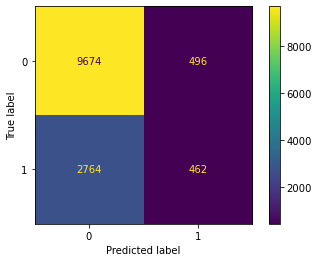

In [163]:
plot_confusion_matrix(xgb_clf, X_test, y_test)  

In [66]:
#Obtain the feature importance and convert to a dataframe
feature_importance = pd.DataFrame(xgb_clf.feature_importances_)
feature_importance = feature_importance.T
feature_importance.columns = X_train.columns

In [68]:
#Sort and print feature importance, just a check
feature_importance.T.sort_values(0, ascending=False)

,0
Precinct_Unknown,0.425884
Frisk Flag_Y,0.017746
Precinct_North,0.017104
Call Type_911,0.013095
Beat_M2,0.011080
...,...
Subject Perceived Race_Other,0.001238
Subject Perceived Gender_Gender Diverse (gender non-conforming and/or transgender),0.001220
Beat_OOJ,0.000333
Beat_S,0.000000


In [69]:
# Consolidate dummy importance values into a single value for the original columns

importance_consolidated = pd.DataFrame(np.zeros(df.columns.size))
importance_consolidated = importance_consolidated.T
importance_consolidated.columns = df.columns

for con_col in importance_consolidated.columns:
    for feat_col in feature_importance.columns:
        if con_col in feat_col:
            importance_consolidated[con_col] += feature_importance[feat_col]

importance_consolidated.drop('Stop Resolution', axis=1, inplace=True)

In [70]:
#Print check
importance_consolidated

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Frisk Flag,Precinct,Sector,Beat,Month,Week,day/night,Officer Age Group
0,0.02606,0.022233,0.005031,0.031379,0.033484,0.008795,0.032855,0.02767,0.468378,0.09234,0.218431,0.003988,0.003823,0.004623,0.020908


In [71]:
#Setup for plotting, need values in different format
values = importance_consolidated.T
values = values[0].sort_values(0, ascending=False)

In [72]:
#Setup for plotting, need indices in different format
ticks = importance_consolidated.T
ticks = ticks[0].sort_values(0, ascending=False).index

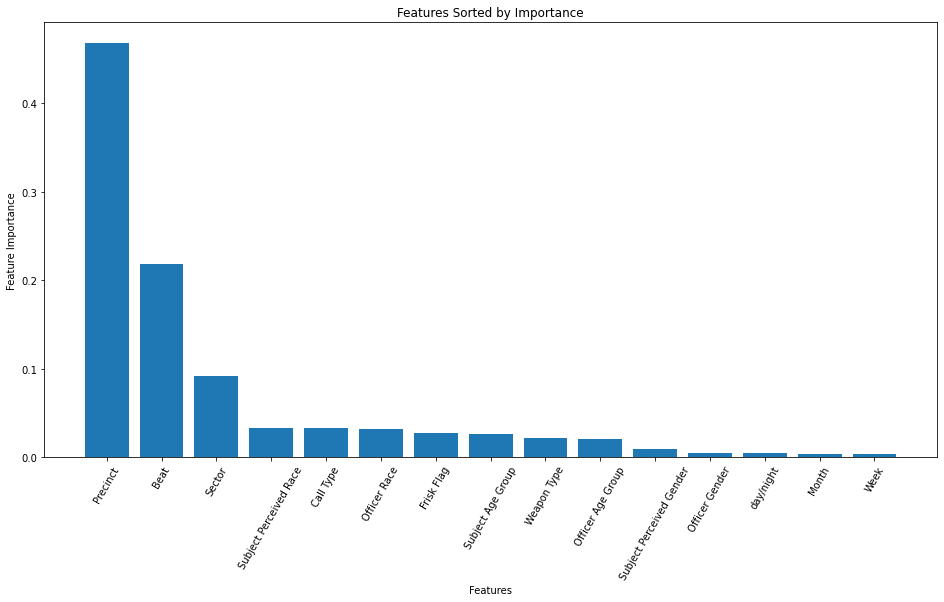

In [73]:
#plot the features
fig = plt.figure(figsize = (16, 8))
plt.bar(x = ticks, 
       height = values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Features Sorted by Importance');

In [74]:
feature_importance

,Month,Week,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,Subject Age Group_36 - 45,Subject Age Group_46 - 55,Subject Age Group_56 and Above,Weapon Type_Firearm,Weapon Type_Lethal Cutting Instrument,...,Beat_U2,Beat_U3,Beat_W1,Beat_W2,Beat_W3,day/night_night,Officer Age Group_26 - 35,Officer Age Group_36 - 45,Officer Age Group_46 - 55,Officer Age Group_56 and Above
0,0.003988,0.003823,0.004788,0.00427,0.004034,0.003999,0.004572,0.004397,0.004667,0.00491,...,0.005269,0.003613,0.005354,0.003464,0.002406,0.004623,0.005261,0.004458,0.005589,0.0056


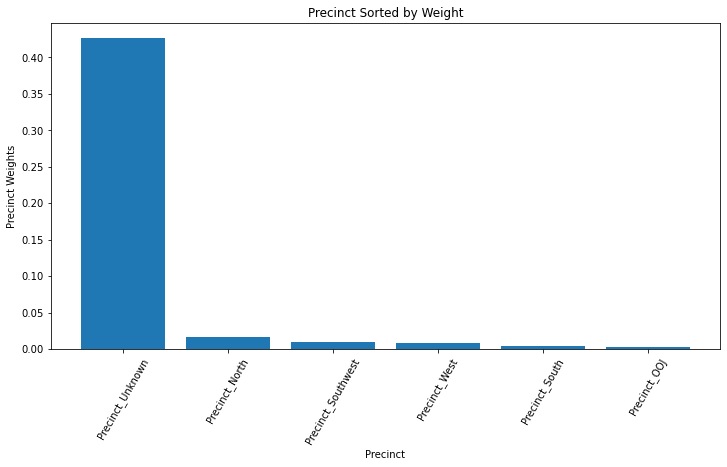

In [89]:
# Essentially the same thing done above, but just for the precinct feature so we can observe
# location based information

precinct_list = []
for col in feature_importance:
    if 'Precinct' in col:
        precinct_list.append(col)

precinct_df = feature_importance[precinct_list]

precinct_weights = precinct_df.T
precinct_weights = precinct_weights[0].sort_values(0, ascending=False)

precinct_labels = precinct_df.T
precinct_labels = precinct_labels[0].sort_values(0, ascending=False).index

fig = plt.figure(figsize = (12, 6))
plt.bar(x = precinct_labels, 
       height = precinct_weights)
plt.xticks(rotation=60)
plt.xlabel('Precinct')
plt.ylabel('Precinct Weights')
plt.title('Precinct Sorted by Weight');

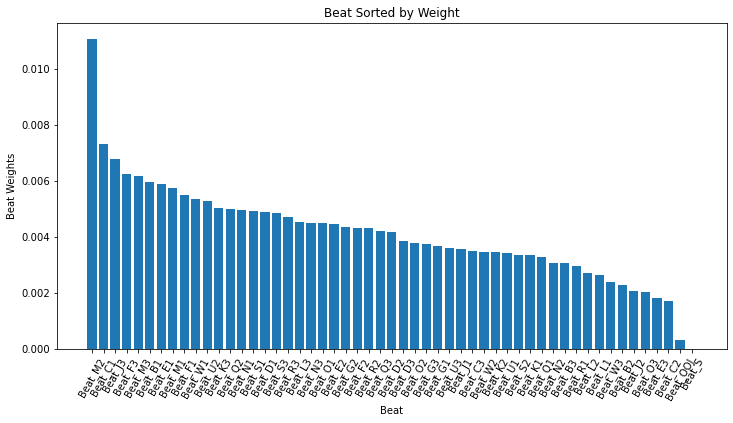

In [92]:
#Repeat of above but for beat
beat_list = []
for col in feature_importance:
    if 'Beat' in col:
        beat_list.append(col)

beat_df = feature_importance[beat_list]

beat_weights = beat_df.T
beat_weights = beat_weights[0].sort_values(0, ascending=False)

beat_labels = beat_df.T
beat_labels = beat_labels[0].sort_values(0, ascending=False).index

fig = plt.figure(figsize = (12, 6))
plt.bar(x = beat_labels, 
       height = beat_weights)
plt.xticks(rotation=60)
plt.xlabel('Beat')
plt.ylabel('Beat Weights')
plt.title('Beat Sorted by Weight');

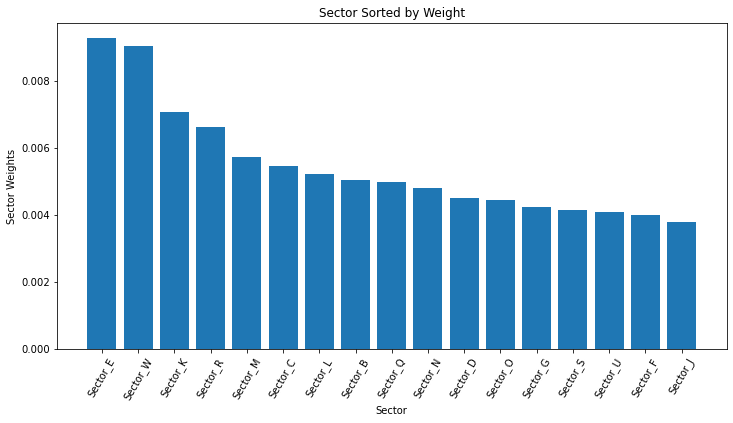

In [93]:
#Repeat of above but for sector
sector_list = []
for col in feature_importance:
    if 'Sector' in col:
        sector_list.append(col)

sector_df = feature_importance[sector_list]

sector_weights = sector_df.T
sector_weights = sector_weights[0].sort_values(0, ascending=False)

sector_labels = sector_df.T
sector_labels = sector_labels[0].sort_values(0, ascending=False).index

fig = plt.figure(figsize = (12, 6))
plt.bar(x = sector_labels, 
       height = sector_weights)
plt.xticks(rotation=60)
plt.xlabel('Sector')
plt.ylabel('Sector Weights')
plt.title('Sector Sorted by Weight');

# Business Recommendations and conversation

The problem statement for this was to create a predictor. I created 4, and all 4 had scores of around 75-80%

In the context of the data, this information should be used strictly for research purposes. In no way should a machine learning model be used to determine whether or not to arrest someone.

My recommendation would be to investigate why precinct is the largest predictor. If we had socioeconomic data we might be able to draw more conclusions about different areas of Seattle and why they see more arrests than others. I would call on the city to provide census data to allow for this further research.
 



## Testing - Adding back in Arrest Flag and seeing results

In [76]:
#df_with_arrest_flag
new_dummies = pd.get_dummies(df_with_arrest_flag, drop_first=True)

In [77]:
y = new_dummies['Stop Resolution']
X = new_dummies.drop('Stop Resolution', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = .25)

In [78]:
#Instantiate the classifier
xgb_clf_2 = XGBClassifier()

# fit the classifier
xgb_clf_2.fit(X_train, y_train)

#Train Scores
train_preds = xgb_clf_2.predict(X_train)

#Test Scores
test_preds = xgb_clf_2.predict(X_test)

#classification report
print('Test Classification Report')
print(classification_report(y_test, test_preds))
print('================================================')
print('Train Classification Report')
print(classification_report(y_train, train_preds))
print('================================================')
print('Train Score: ', xgb_clf_2.score(X_train, y_train))
print('================================================')
print('Test Score: ', xgb_clf_2.score(X_test, y_test))
print('================================================')

Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     10170
           1       0.89      0.43      0.58      3226

    accuracy                           0.85     13396
   macro avg       0.87      0.71      0.75     13396
weighted avg       0.86      0.85      0.83     13396

Train Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     30295
           1       0.96      0.48      0.64      9892

    accuracy                           0.87     40187
   macro avg       0.91      0.74      0.78     40187
weighted avg       0.88      0.87      0.85     40187

Train Score:  0.8665488839674521
Test Score:  0.8503284562555987


Adding the 'Arrest Flag column improved results by 6-10% between the training and test sets.

If the goal is to use old data where we always have this column available, it is the best predictor

If the goal is to predict the outcome, where this value isn't known, the models perform just barely better than random guessing.

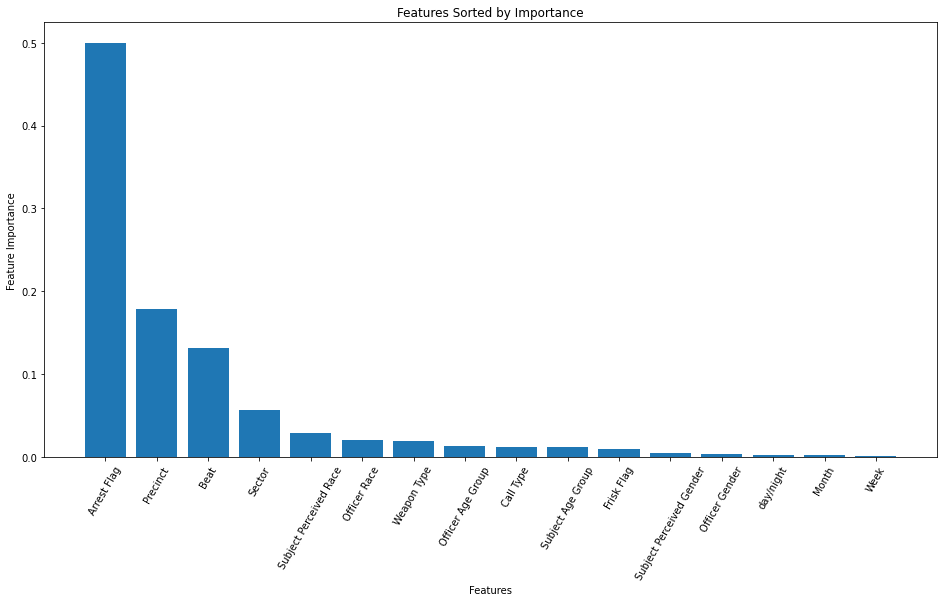

In [79]:
feature_importance_2 = pd.DataFrame(xgb_clf_2.feature_importances_)
feature_importance_2 = feature_importance_2.T
feature_importance_2.columns = X_train.columns

# Consolidate dummy importance values into a single value for the original columns

importance_consolidated_2 = pd.DataFrame(np.zeros(df_with_arrest_flag.columns.size))
importance_consolidated_2 = importance_consolidated_2.T
importance_consolidated_2.columns = df_with_arrest_flag.columns

for con_col in importance_consolidated_2.columns:
    for feat_col in feature_importance_2.columns:
        if con_col in feat_col:
            importance_consolidated_2[con_col] += feature_importance_2[feat_col]

importance_consolidated_2.drop('Stop Resolution', axis=1, inplace=True)

values = importance_consolidated_2.T
values = values[0].sort_values(0, ascending=False)

ticks = importance_consolidated_2.T
ticks = ticks[0].sort_values(0, ascending=False).index

fig = plt.figure(figsize = (16, 8))
plt.bar(x = ticks, 
       height = values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Features Sorted by Importance');


## Rerun XGBoost by removing 2 of Beat/Sector/Pricinct

Bar chart of model results in presentation

Include the study I found

## About the data

In [95]:
about_data = pd.read_csv('Terry_Stops.csv')

In [99]:
about_data['Reported Date'].sort_values()

1928     2015-03-15T00:00:00Z
3913     2015-03-16T00:00:00Z
3914     2015-03-16T00:00:00Z
32360    2015-03-16T00:00:00Z
32874    2015-03-17T00:00:00Z
                 ...         
41165    2022-10-22T00:00:00Z
32346    2022-10-22T00:00:00Z
14389    2022-10-22T00:00:00Z
12452    2022-10-22T00:00:00Z
28583    2022-10-22T00:00:00Z
Name: Reported Date, Length: 53654, dtype: object

Ranges from March 2015 to october 2022

## Model Metrics Chart

In [103]:
model_dict = {
    'Logistic Regression Train Score': 75.3,
    'Logistic Regression Test Score': 75.8,
    'Perceptron Train Score': 74.8,
    'Perceptron Test Score': 73.4,
    'Decision Tree Train Score': 75.4,
    'Decision Tree Test Score': 75.9,
    'XGBoost Train Score': 79.9,
    'XGBoost Test Score': 76.5
}

labels = ['Logistic Regression', 'Perceptron', 'Decision Tree', 'XGBoost']
train_scores = [75.3, 74.8, 75.4, 79.9]
test_scores = [75.8, 73.4, 75.9, 76.5]

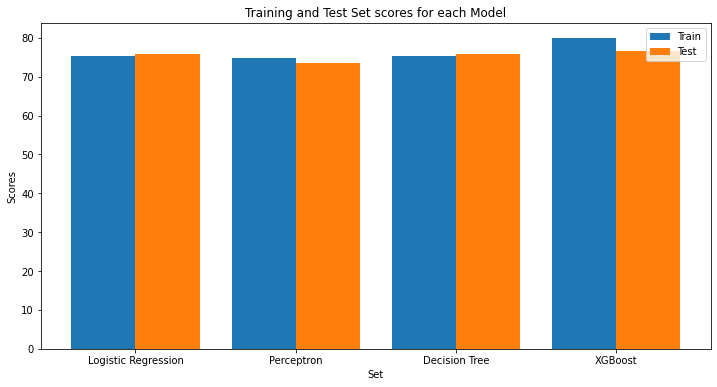

In [115]:
fig = plt.figure(figsize = (12, 6))

X_axis = np.arange(len(labels))
  
plt.bar(X_axis - 0.2, train_scores, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, test_scores, 0.4, label = 'Test')
  
plt.xticks(X_axis, labels)
plt.xlabel("Set")
plt.ylabel("Scores")
plt.title("Training and Test Set scores for each Model")
plt.legend()
plt.show()

## Testing Dropping Sector and Beat

In [164]:
loc = ['Sector', 'Beat']
df = df.drop(loc, axis=1)

In [165]:
#obtain dummies
dummy_df = pd.get_dummies(df, drop_first=True)

In [166]:
# Data X and Y

y = dummy_df['Stop Resolution']
X = dummy_df.drop('Stop Resolution', axis=1)

In [167]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = .25)

In [168]:
#Instantiate the classifier
xgb_clf = XGBClassifier()

# fit the classifier
xgb_clf.fit(X_train, y_train)

#Train Scores
train_preds = xgb_clf.predict(X_train)

#Test Scores
test_preds = xgb_clf.predict(X_test)

#classification report
print('Test Classification Report')
print(classification_report(y_test, test_preds))
print('================================================')
print('Train Classification Report')
print(classification_report(y_train, train_preds))
print('================================================')
print('Train Score: ', xgb_clf.score(X_train, y_train))
print('================================================')
print('Test Score: ', xgb_clf.score(X_test, y_test))
print('================================================')


Test Classification Report
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     10170
           1       0.50      0.13      0.21      3226

    accuracy                           0.76     13396
   macro avg       0.64      0.54      0.53     13396
weighted avg       0.71      0.76      0.70     13396

Train Classification Report
              precision    recall  f1-score   support

           0       0.79      0.98      0.88     30295
           1       0.77      0.22      0.34      9892

    accuracy                           0.79     40187
   macro avg       0.78      0.60      0.61     40187
weighted avg       0.79      0.79      0.74     40187

Train Score:  0.7914499713837808
Test Score:  0.7591818453269633


In [169]:
#Obtain the feature importance and convert to a dataframe
feature_importance = pd.DataFrame(xgb_clf.feature_importances_)
feature_importance = feature_importance.T
feature_importance.columns = X_train.columns

In [170]:
#Sort and print feature importance, just a check
feature_importance.T.sort_values(0, ascending=False)

,0
Precinct_Unknown,0.518681
Frisk Flag_Y,0.031207
Call Type_911,0.027104
Frisk Flag_N,0.023215
Subject Perceived Race_Unknown,0.020606
Weapon Type_None,0.018367
Precinct_North,0.014847
Call Type_ONVIEW,0.014774
"Call Type_TELEPHONE OTHER, NOT 911",0.012664
Precinct_Southwest,0.011894


In [171]:
# Consolidate dummy importance values into a single value for the original columns

importance_consolidated = pd.DataFrame(np.zeros(df.columns.size))
importance_consolidated = importance_consolidated.T
importance_consolidated.columns = df.columns

for con_col in importance_consolidated.columns:
    for feat_col in feature_importance.columns:
        if con_col in feat_col:
            importance_consolidated[con_col] += feature_importance[feat_col]

importance_consolidated.drop('Stop Resolution', axis=1, inplace=True)

In [172]:
#Print check
importance_consolidated

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Frisk Flag,Precinct,Month,Week,day/night,Officer Age Group
0,0.052496,0.04142,0.008693,0.058335,0.064188,0.018117,0.064331,0.054423,0.571719,0.007634,0.008046,0.009114,0.041484


In [173]:
#Setup for plotting, need values in different format
values = importance_consolidated.T
values = values[0].sort_values(0, ascending=False)

In [174]:
#Setup for plotting, need indices in different format
ticks = importance_consolidated.T
ticks = ticks[0].sort_values(0, ascending=False).index

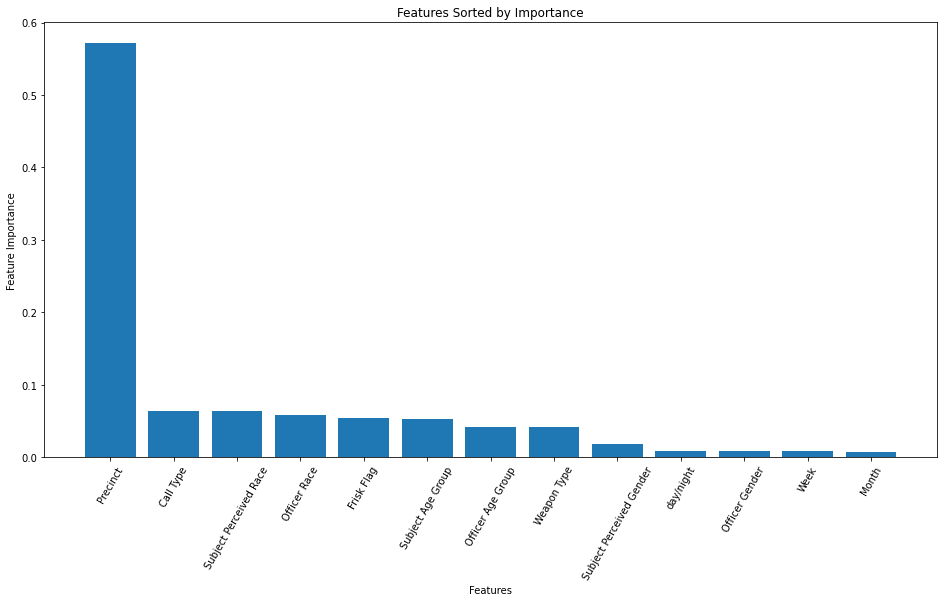

In [175]:
#plot the features
fig = plt.figure(figsize = (16, 8))
plt.bar(x = ticks, 
       height = values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Features Sorted by Importance');